In [1]:
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

Original R-squared: 9.956e-01


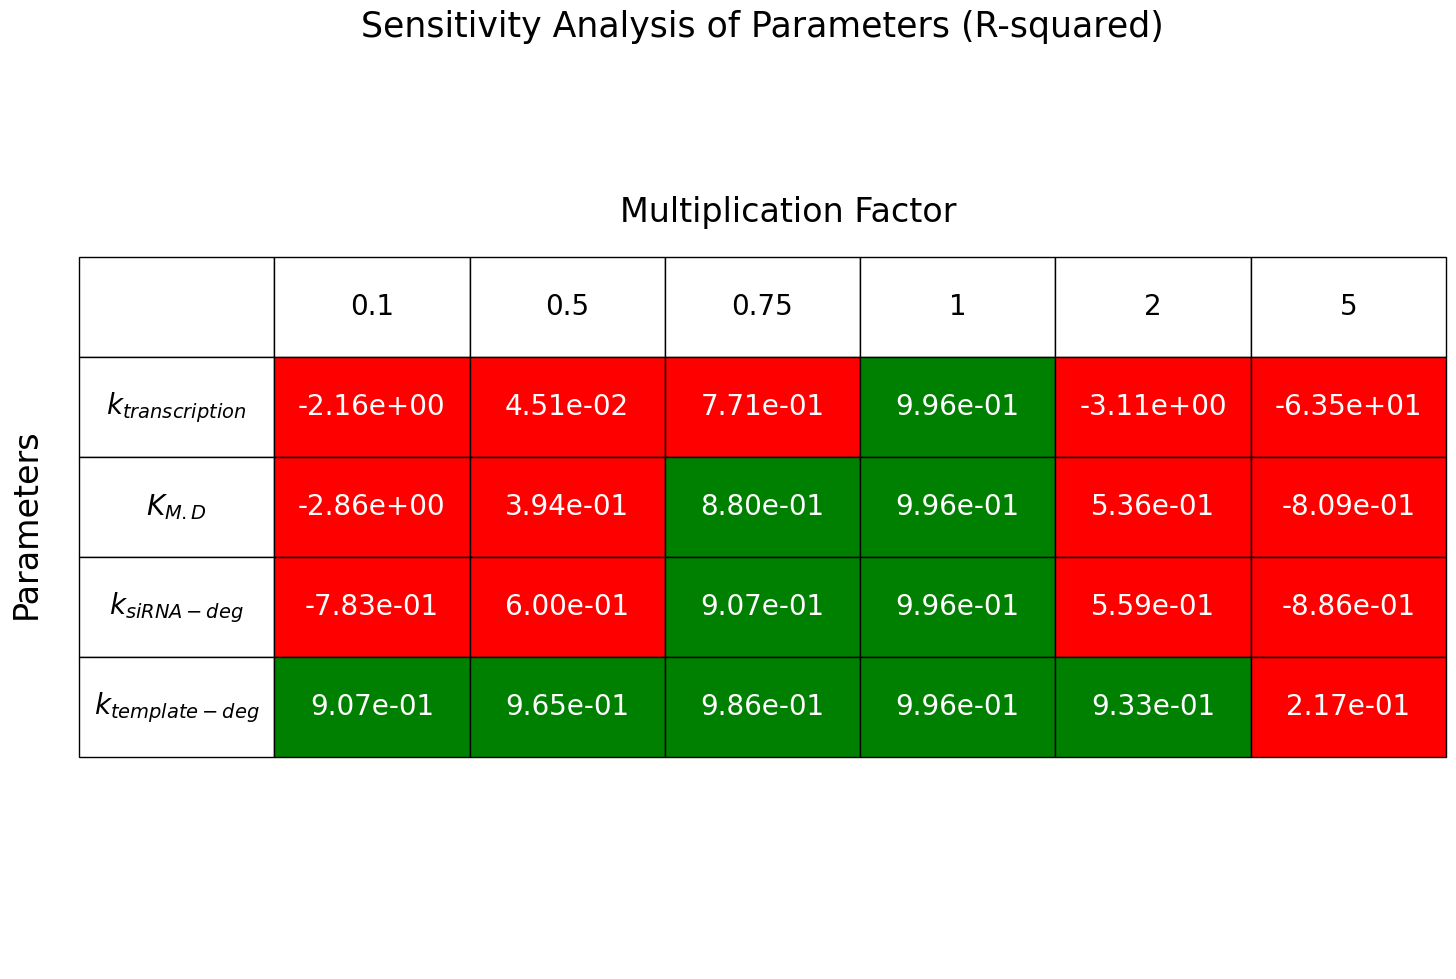

In [2]:
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def kinetics(y, t, k_trans, Km, k_deg_mRNA, k_deg_template, k_deg_T7RNAP):
    # Tracked Species
    mRNA, template, T7RNAP = y
    
    # Equations
    dmRNAdt = (k_trans * T7RNAP * template / (Km + template)) - k_deg_mRNA * mRNA
    dtemplatedt = - k_deg_template * template
    dT7RNAPdt = - k_deg_T7RNAP * T7RNAP
   
    solutions = [dmRNAdt, dtemplatedt, dT7RNAPdt]
    
    return solutions

# Given data
time_siRNA = [0, 30, 60, 120, 180, 240, 300, 360]
siRNA = [0.6363, 22.4601, 39.6522, 70.6216, 82.2025, 103.0685, 109.4651, 112.6576]

# Initial conditions and parameters
y0_model = [0, 1, 0.21]
t_interval = np.linspace(0, 360, 5000)
parameter_set_1 = [7.033, 0.936, 0.0043, 0.0016, 0]

k_trans, Km, k_deg_mRNA, k_deg_template, k_deg_T7RNAP = parameter_set_1

# Solve ODE with the original parameters
sol = odeint(kinetics, y0_model, t_interval, args=(k_trans, Km, k_deg_mRNA, k_deg_template, k_deg_T7RNAP))
solved_1 = sol.transpose()

# Extract model predictions at the time points of the given data
mRNA_model = np.interp(time_siRNA, t_interval, solved_1[0])

# Calculate R-squared
original_r_squared = r2_score(siRNA, mRNA_model)
print(f'Original R-squared: {original_r_squared:.3e}')  # Display R-squared in scientific notation

# Define a function to calculate R-squared given a parameter set
def calculate_r_squared(params):
    k_trans, Km, k_deg_mRNA, k_deg_template, k_deg_T7RNAP = params
    sol = odeint(kinetics, y0_model, t_interval, args=(k_trans, Km, k_deg_mRNA, k_deg_template, k_deg_T7RNAP))
    solved_1 = sol.transpose()
    mRNA_model = np.interp(time_siRNA, t_interval, solved_1[0])
    return r2_score(siRNA, mRNA_model)

# Perform sensitivity analysis
sensitivity_factors = [0.1, 0.5, 0.75, 1, 2, 5]
r_squared_matrix = []

for i, param in enumerate(parameter_set_1):
    r_squared_values = []
    for factor in sensitivity_factors:
        varied_params = parameter_set_1.copy()
        varied_params[i] = param * factor
        r_squared = calculate_r_squared(varied_params)
        r_squared_values.append(r_squared)
    r_squared_matrix.append(r_squared_values)

# Convert to numpy array for easy plotting
r_squared_matrix = np.array(r_squared_matrix)

# Create a table grid visualization
parameter_names = ['$k_{transcription}$', '$K_{M.D}$', '$k_{siRNA-deg}$', '$k_{template-deg}$']

fig, ax = plt.subplots(figsize=(12, 12))  # Adjusted figure size for a bigger and more square shape
ax.axis('tight')
ax.axis('off')

# Create color map
cmap = mcolors.ListedColormap(['red', 'green'])
bounds = [0, 0.8, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create table data
table_data = [[''] + sensitivity_factors]  # Header row
for i, param_name in enumerate(parameter_names):
    row = [param_name] + [f'{r2:.2e}' for r2 in r_squared_matrix[i]]
    table_data.append(row)

# Create the table
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.07] * (len(sensitivity_factors) + 1))

# Color cells based on R-squared values
for i in range(1, len(parameter_names) + 1):
    for j in range(1, len(sensitivity_factors) + 1):
        cell = table[(i, j)]
        r2_value = r_squared_matrix[i - 1, j - 1]
        cell.set_facecolor(cmap(norm(r2_value)))
        cell.set_text_props(color='white')

table.auto_set_font_size(False)
table.set_fontsize(20)
table.scale(3.0, 6.0)  # Adjust scale to make the table bigger

plt.title('Sensitivity Analysis of Parameters (R-squared)', fontsize=25)
# Add labels for x and y axis
ax.text(0.003, 0.034, 'Multiplication Factor', ha='center', fontsize=24)
ax.text(-0.089, -0.002, 'Parameters', va='center', rotation='vertical', fontsize=24)
plt.show()
